Epoch [1/5] Loss: 0.9831
Epoch [2/5] Loss: 0.6928
Epoch [3/5] Loss: 0.6168
Epoch [4/5] Loss: 0.5753
Epoch [5/5] Loss: 0.5531


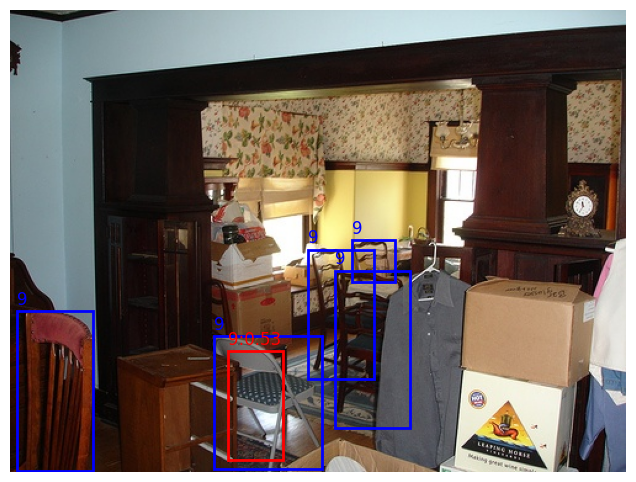

In [ ]:
# 비전 모델
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, models, ops
from torchvision.datasets import VOCDetection
from torchvision.models.detection import rpn, FasterRCNN
import torch.optim as optim

class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, year, image_set, transform=None):
        super().__init__()
        self.voc = VOCDetection(
            root=root,
            year=year,
            image_set=image_set,
            download=True
        )
        self.transform = transform
        
        # Pascal VOC 클래스명 → 인덱스 매핑
        self.class_to_idx = {
            'aeroplane':1, 'bicycle':2, 'bird':3, 'boat':4,
            'bottle':5, 'bus':6, 'car':7, 'cat':8,
            'chair':9, 'cow':10, 'diningtable':11, 'dog':12,
            'horse':13, 'motorbike':14, 'person':15,
            'pottedplant':16, 'sheep':17, 'sofa':18,
            'train':19, 'tvmonitor':20
        }
        
    def __len__(self):
        return len(self.voc)

    def __getitem__(self, idx):
        # 1) VOCDetection이 돌려주는 튜플 (PIL, target_dict)
        image, anno = self.voc[idx]
        # 2) 어노테이션 파싱
        objs = anno['annotation']['object']
        if not isinstance(objs, list):
            objs = [objs]

        boxes = []
        labels = []
        for obj in objs:
            bndbox = obj['bndbox']
            xmin = float(bndbox['xmin'])
            ymin = float(bndbox['ymin'])
            xmax = float(bndbox['xmax'])
            ymax = float(bndbox['ymax'])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.class_to_idx[obj['name']])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id
        }

        # 3) transform 적용
        if self.transform:
            image = self.transform(image)

        return image, target

# collate 함수
def collator(batch):
    return tuple(zip(*batch))

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

VOC_ROOT = "VOCdevkit/VOC2007"  # 실제 경로로 변경하세요

train_dataset = VOCDataset(root=VOC_ROOT, year="2007", image_set="train", transform=transform)
val_dataset   = VOCDataset(root=VOC_ROOT, year="2007", image_set="val",   transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          drop_last=True, collate_fn=collator)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False,
                          drop_last=False, collate_fn=collator)

backbone = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
backbone.out_channels = 512

anchor_generator = rpn.AnchorGenerator(
    sizes=((32,64,128,256,512),),
    aspect_ratios=((0.5,1.0,2.0),)
)

roi_pooler = ops.MultiScaleRoIAlign(
    featmap_names=["0"],
    output_size=(7,7),
    sampling_ratio=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Pascal VOC 클래스 수 = 20 + 1(background)
model = FasterRCNN(
    backbone=backbone,
    num_classes=21,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
).to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=5e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0

    for images, targets in train_loader:
        imgs = [img.to(device) for img in images]
        tgts = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(imgs, tgts)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    lr_scheduler.step()
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss: {total_loss/len(train_loader):.4f}")


def draw_bbox(ax, box, label, color="red"):
    ax.add_patch( plt.Rectangle(
        (box[0], box[1]),
        box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=2
    ))
    ax.annotate(label, (box[0], box[1]-5), color=color, fontsize=12)

model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        imgs = [img.to(device) for img in images]
        outputs = model(imgs)[0]

        img = transforms.ToPILImage()(images[0].cpu())
        fig, ax = plt.subplots(1, figsize=(8,6))
        ax.imshow(img)

        # predictions
        for box, score, lbl in zip(outputs["boxes"], outputs["scores"], outputs["labels"]):
            if score > 0.5:
                draw_bbox(ax, box.cpu().numpy(), f"{lbl.item()}:{score:.2f}")

        # ground truths
        for box, lbl in zip(targets[0]["boxes"], targets[0]["labels"]):
            draw_bbox(ax, box.cpu().numpy(), str(lbl.item()), color="blue")

        plt.axis("off")
        plt.show()
        break


In [ ]:
# 언어 모델

import os
import torch
import numpy as np
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim

# 1) IMDB 데이터셋 로드 및 분할
dataset = load_dataset("imdb")
train_val = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_data = train_val["train"]
valid_data = train_val["test"]
test_data  = dataset["test"]

print(f"Train size: {len(train_data)}, Valid size: {len(valid_data)}, Test size: {len(test_data)}")

# 2) 토크나이저 설정
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer.pad_token = tokenizer.eos_token if tokenizer.pad_token is None else tokenizer.pad_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3) 데이터셋 만들기
def make_dataset(split_data, tokenizer, device, max_length=256):
    input_ids, attention_masks, labels = [], [], []
    for ex in split_data:
        enc = tokenizer(
            ex["text"],
            max_length=max_length,
            truncation=True,
            padding="longest",
            return_tensors="pt"
        )
        ids = enc["input_ids"].squeeze(0)
        mask = enc["attention_mask"].squeeze(0)
        lbl = torch.tensor(ex["label"], dtype=torch.long)
        input_ids.append(ids)
        attention_masks.append(mask)
        labels.append(lbl)
    # 패딩
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return TensorDataset(
        input_ids.to(device),
        attention_masks.to(device),
        labels.to(device)
    )

train_dataset = make_dataset(train_data, tokenizer, device)
valid_dataset = make_dataset(valid_data, tokenizer, device)
test_dataset  = make_dataset(test_data,  tokenizer, device)

# 4) DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, sampler=SequentialSampler(valid_dataset), batch_size=batch_size)
test_loader  = DataLoader(test_dataset,  sampler=SequentialSampler(test_dataset),  batch_size=batch_size)

# 5) 모델 선언 및 옵티마이저
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
).to(device)

model.config.pad_token_id = tokenizer.pad_token_id

optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
criterion = nn.CrossEntropyLoss()

# 6) 학습/평가 함수
def calc_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.cpu().numpy().flatten()
    return (pred_flat == labels_flat).sum() / len(labels_flat)

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for input_ids, attn_mask, labels in loader:
        outputs = model(
            input_ids=input_ids,
            attention_mask=attn_mask,
            labels=labels
        )
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for input_ids, attn_mask, labels in loader:
            outputs = model(
                input_ids=input_ids,
                attention_mask=attn_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits.cpu().numpy()
            total_loss += loss.item()
            total_acc += calc_accuracy(logits, labels)
    return total_loss / len(loader), total_acc / len(loader)

# 7) 메인 학습 루프
epochs = 3
best_val_loss = float("inf")

for epoch in range(1, epochs+1):
    train_loss = train_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, valid_loader)
    print(f"Epoch {epoch}: Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "bert_imdb.pt")
        print("→ Saved best model")

# 8) 테스트
model.load_state_dict(torch.load("bert_imdb.pt"))
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Loss {test_loss:.4f} | Test Acc {test_acc:.4f}")


/home/user/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train size: 22500, Valid size: 2500, Test size: 25000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss 0.2774 | Val Loss 0.2059 | Val Acc 0.9140
→ Saved best model
Epoch 2: Train Loss 0.1439 | Val Loss 0.2348 | Val Acc 0.9148
Epoch 3: Train Loss 0.0705 | Val Loss 0.3251 | Val Acc 0.9080
Test Loss 0.1976 | Test Acc 0.9232
